In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import cm
from datetime import datetime, timedelta
from pytz import timezone
import pytz
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import matplotlib
import scipy.signal as signal



jet= cm.get_cmap('jet', 22)


# import os
# os.environ["PROJ_LIB"] = "C:\\Users\\USUARIO\\Anaconda3\\Library\\share"
# from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.basemap import Basemap
# from matplotlib.patches import Polygon

import matplotlib as mpl
plt.style.use('seaborn-paper')
mpl.rcParams['xtick.labelsize']=13
mpl.rcParams['ytick.labelsize']=13
mpl.rcParams['font.sans-serif'] = 'Century Gothic'
mpl.rcParams['font.family'] = 'Century Gothic'
mpl.rcParams['font.weight'] = 'normal'

# Lectura de datos 

In [2]:
paths = glob.glob(r"E:\Documentos\DATOS_SAI_TODOS\DATOS_SAI_4_15_nov_2021\CTD\Emisario\Datos_CTD_131121_CSV\*.csv")

In [3]:
len(paths)

27

## Metadatos

In [4]:
metadata = pd.read_csv(paths[0], delimiter = ",", nrows = 23,names=['Device', 'Value']) # Modeficar ruta
for i in range (0, metadata.shape[0]):
    if metadata['Device'].values[i][0:2]=='% ':
        metadata['Device'][i] = metadata['Device'][i][2:len(metadata['Device'][i])] 
    
# metadata.set_index("% Device")
metadata

,Device,Value
0,Device,CC1314009
1,File name,CC1314009_20211113_131615
2,Cast time (UTC),2021-11-13 13:16:15
3,Cast time (local),2021-11-13 08:16:15
4,Sample type,Cast
5,Cast data,Processed
6,Location source,GPS
7,Default latitude,32
8,Default altitude,0
9,Start latitude,12.5732118


## Datos

In [5]:
data = pd.read_csv(paths[14], delimiter = ",", header = 28) # Modeficar ruta
df = pd.DataFrame(data = np.c_[data['Depth (Meter)'].values,data['Temperature (Celsius)'].values,\
                               data['Salinity (Practical Salinity Scale)'].values], columns =['Depth','Temp','Sal'])
df

,Depth,Temp,Sal
0,0.149923,28.979916,35.873499
1,0.449767,28.979300,35.873394
2,0.749609,28.986940,35.905785
3,1.049440,28.990296,35.960601
4,1.349264,28.986335,35.975065
5,1.649087,28.988822,35.966880
6,1.948911,28.988265,35.962672
7,2.248734,28.985232,35.972499
8,2.548555,28.985126,35.979308
9,2.848374,28.986167,35.976949


# Crear diccionario

In [6]:
%%time
Datos = {}
Datos_Dp = {}
time = []
lat = np.zeros(shape = len(paths))
lon = np.zeros(shape = len(paths))
DepthEnd = np.zeros(shape=len(paths))
for i in range (0, len(paths)):
    metadata = pd.read_csv(paths[i], delimiter = ",", nrows = 23,names=['Device', 'Value']) # Modeficar ruta
    for j in range (0, metadata.shape[0]):
        if metadata['Device'].values[j][0:2]=='% ':
            metadata['Device'][j] = metadata['Device'][j][2:len(metadata['Device'][j])]   
    # metadata.set_index("% Device")
    lat[i] = float(metadata[metadata.Device == 'Start latitude'].Value.values)
    lon[i] = float(metadata[metadata.Device == 'Start longitude'].Value.values)
    Time = metadata[metadata.Device == 'Cast time (local)'].Value.values
    time.append(Time)
    if (i < 9):
        name = 'EP0'+str(i+1)+' '+str(Time[0])
    else:
        name = 'EP'+str(i+1)+' '+str(Time[0])
#     print(name)
    data = pd.read_csv(paths[i], delimiter = ",", header = 28) # Modeficar ruta
    df = pd.DataFrame(data = np.c_[data['Depth (Meter)'].values,data['Temperature (Celsius)'].values,\
                               data['Salinity (Practical Salinity Scale)'].values], columns =['Depth','Temp','Sal'])
    DepthEnd[i] = df.Depth.values[-1]
    depthstr = str(round(df.Depth.values[-1],4))
    if str(round(df.Depth.values[-1],1))[1]== '.':
        depthstr = '0'+ depthstr
    else: 
        pass
    
    if (i < 9):
        name_Depth = depthstr+'_EP0'+str(i+1)
    else:
        name_Depth = depthstr+'_EP'+str(i+1)
    Datos.setdefault(name,df)
    Datos_Dp.setdefault(name_Depth,df)
Puntos = [i for i in Datos.keys()]            # Obtener las variables del espectro 
Puntos
Puntos_Dp = sorted(Datos_Dp.keys())
Puntos_Dp

Wall time: 1.67 s


['03.0071_EP13',
 '03.4823_EP08',
 '09.7536_EP14',
 '10.2668_EP20',
 '10.4768_EP21',
 '11.0046_EP15',
 '11.4954_EP01',
 '12.1859_EP02',
 '12.2881_EP12',
 '12.4575_EP27',
 '14.216_EP23',
 '16.37_EP09',
 '16.8074_EP26',
 '31.0282_EP03',
 '35.1755_EP19',
 '37.2299_EP16',
 '48.1236_EP22',
 '60.5369_EP04',
 '75.6689_EP11',
 '76.9987_EP05',
 '77.7303_EP25',
 '77.807_EP10',
 '78.6422_EP18',
 '80.4366_EP17',
 '80.9019_EP24',
 '81.8357_EP07',
 '81.8438_EP06']

# Gráficas de perfiles

C:\Users\USUARIO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


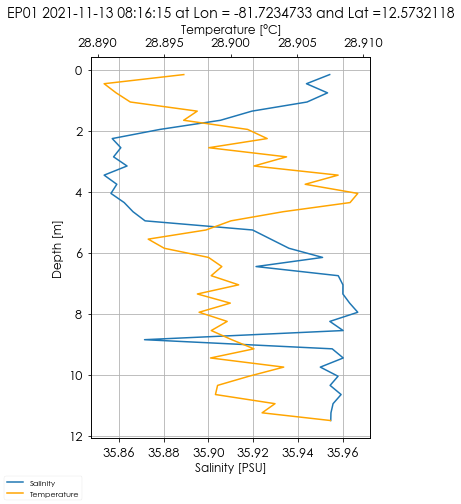

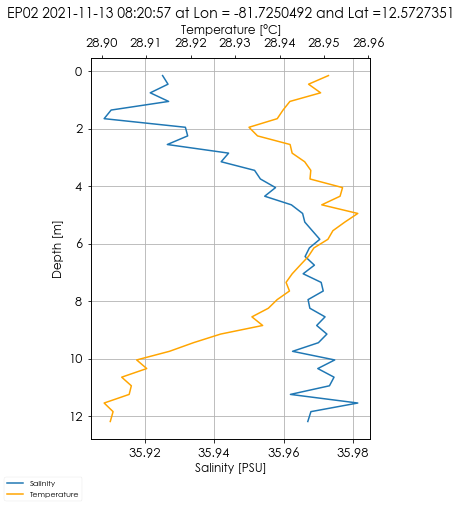

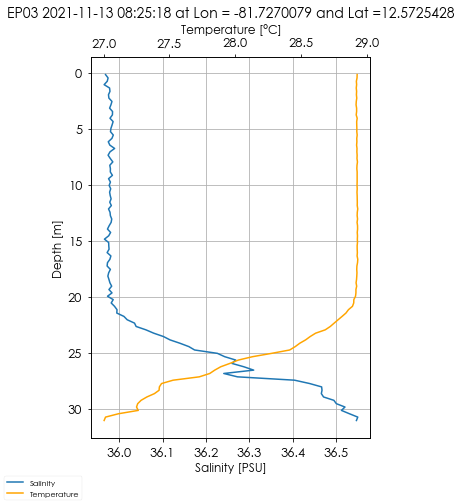

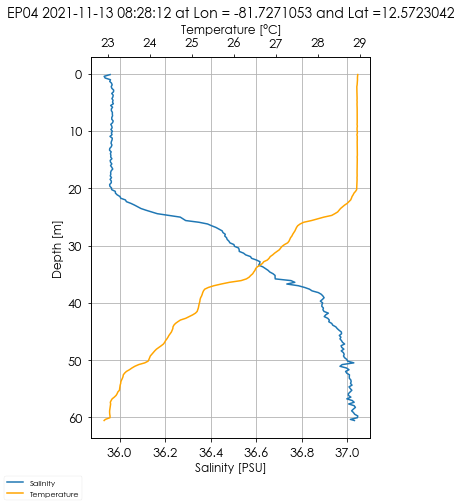

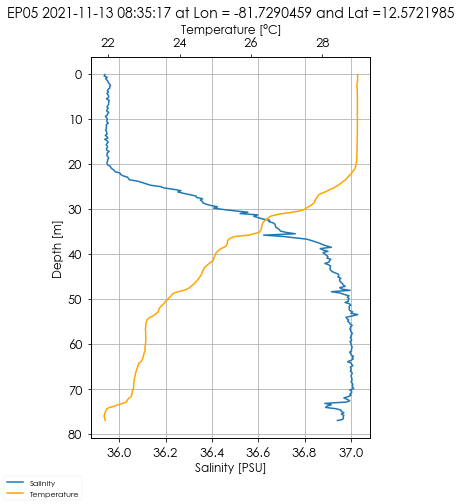

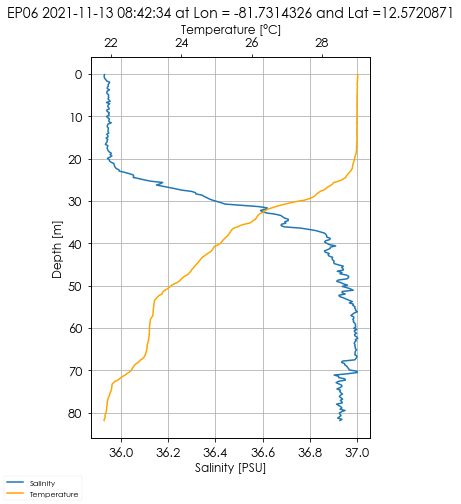

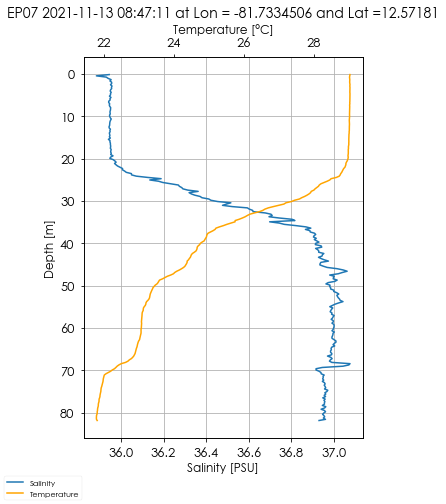

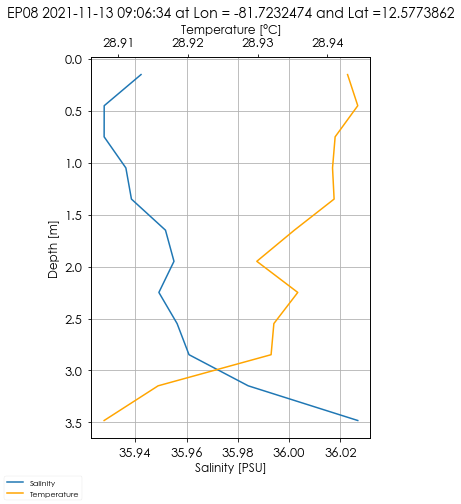

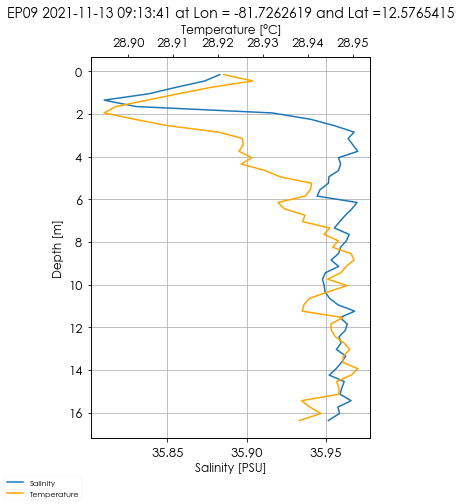

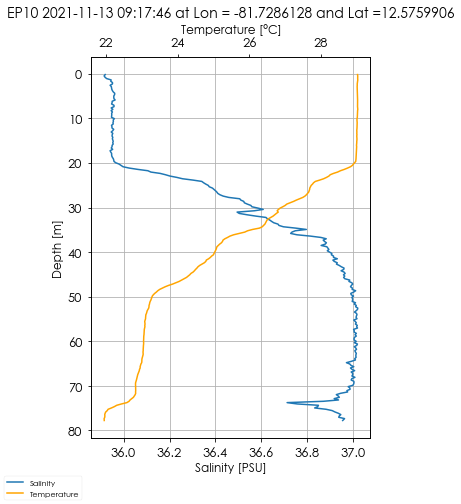

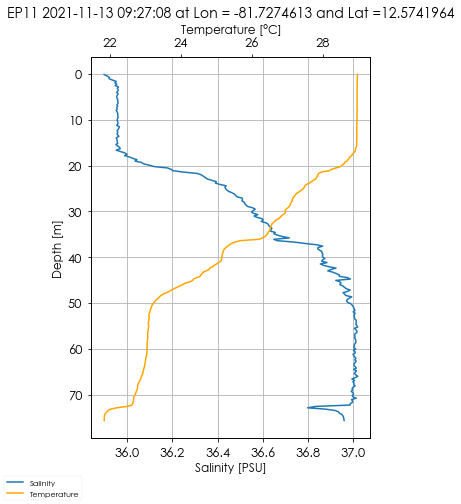

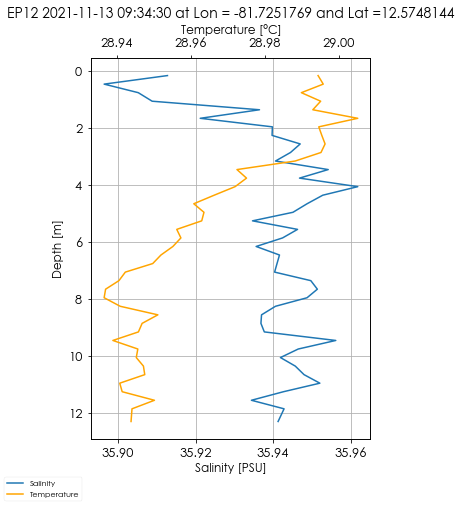

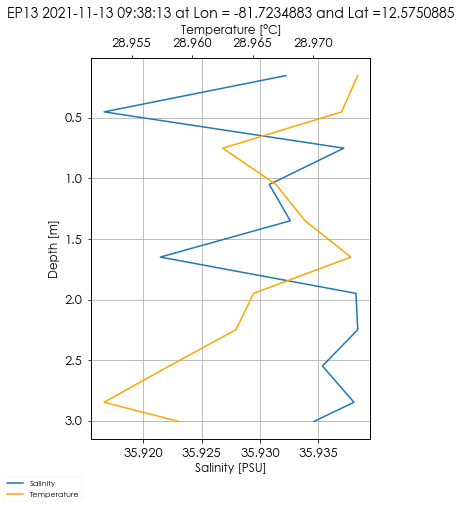

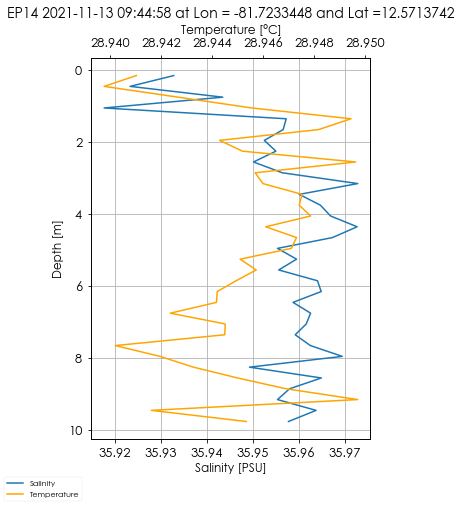

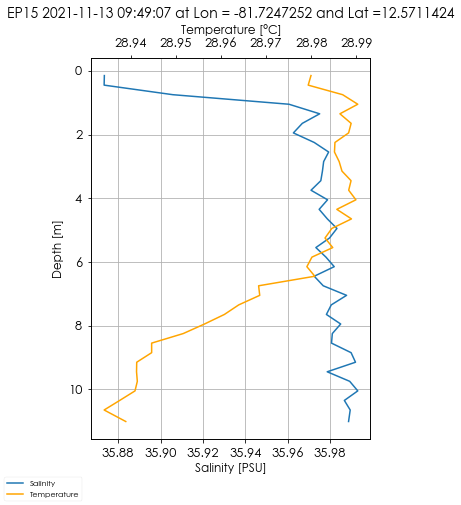

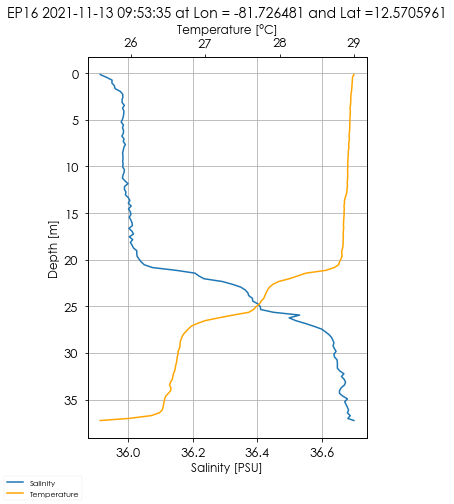

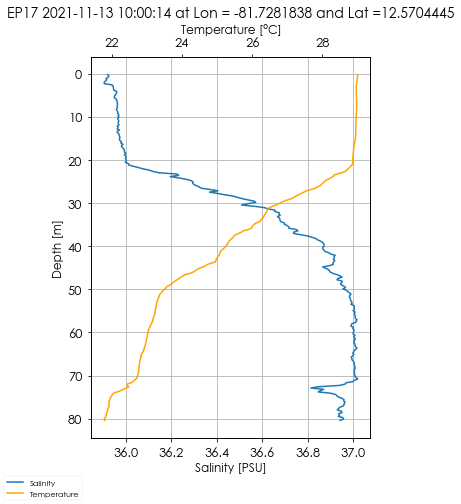

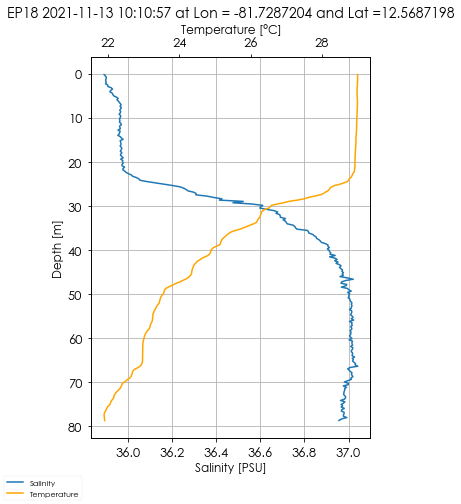

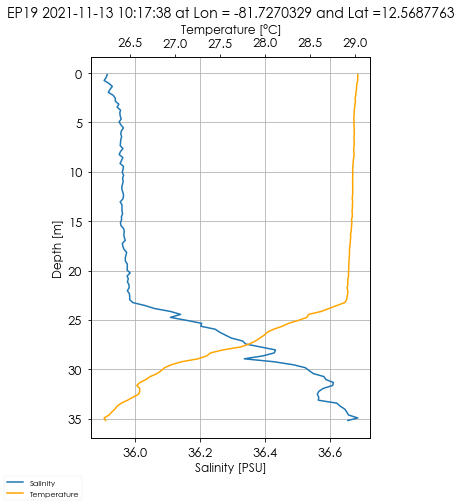

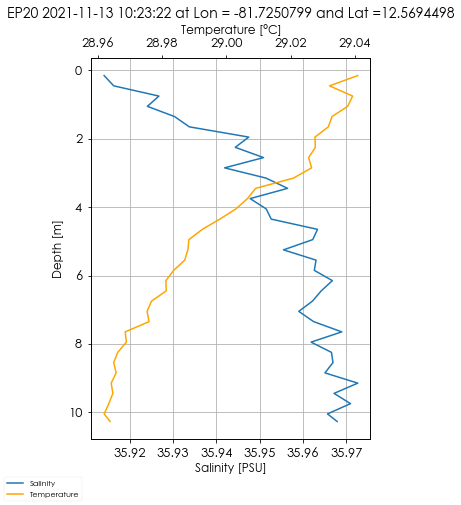

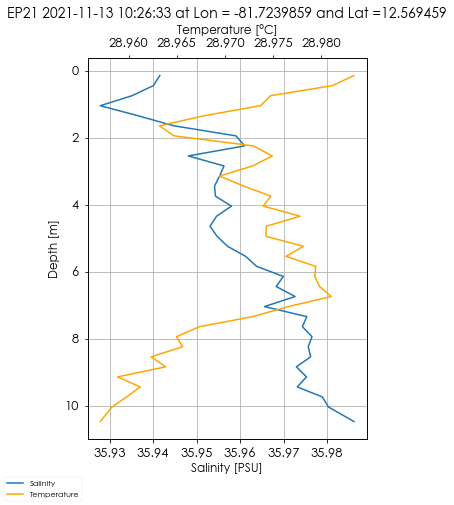

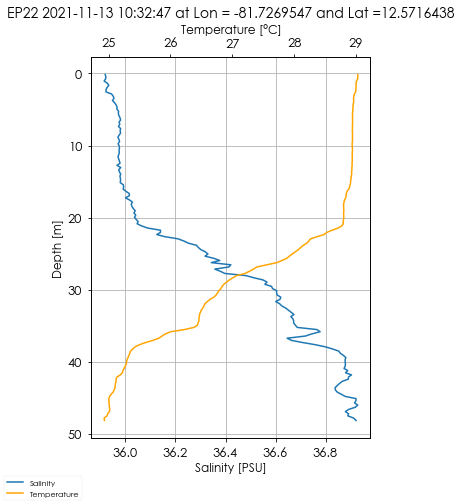

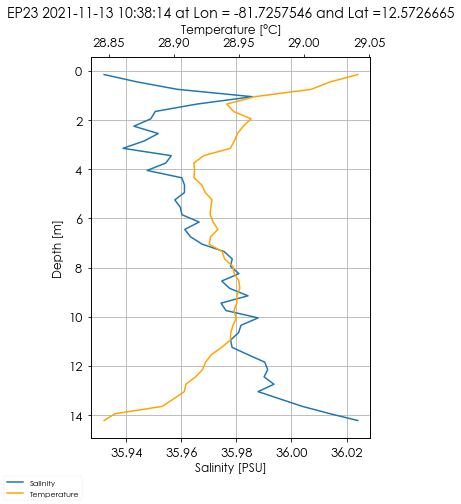

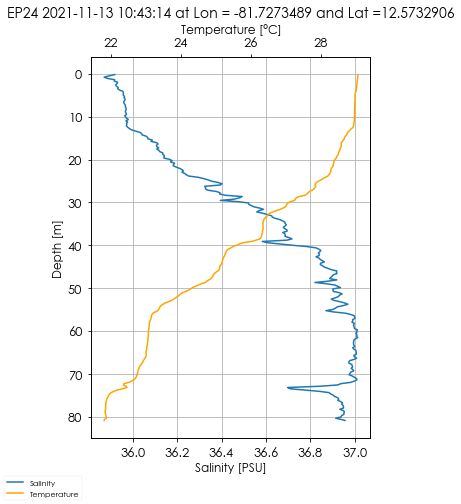

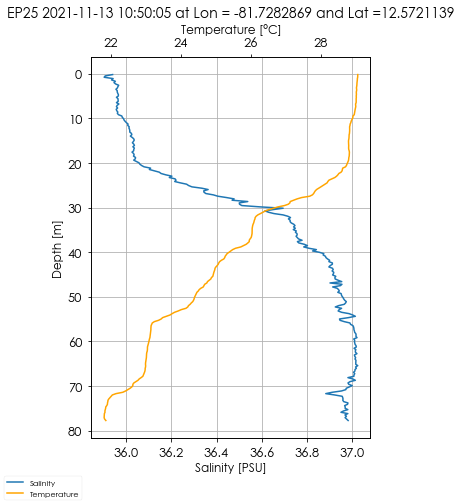

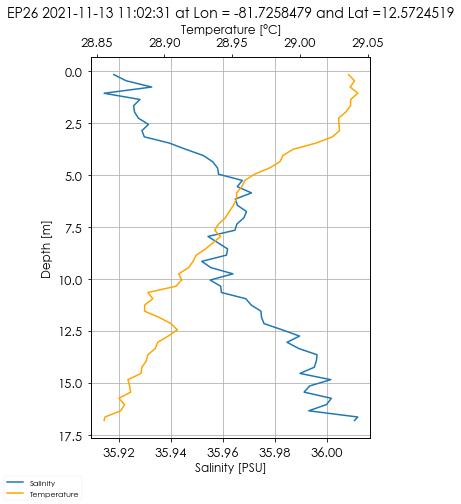

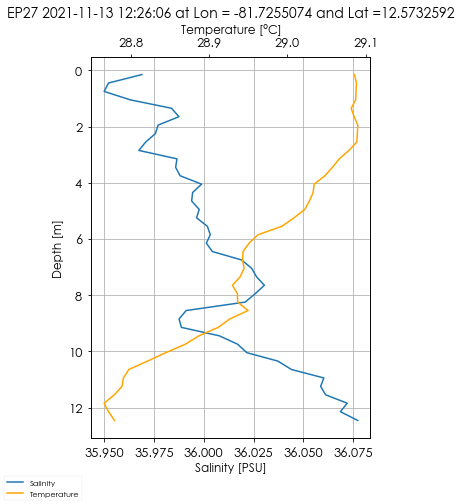

In [7]:
for i in range (0, len(paths)):
    fig, ax = plt.subplots(figsize=(5,7))
    p1 = ax.plot(Datos[Puntos[i]].Sal.values,Datos[Puntos[i]].Depth.values,lw=1.5,alpha=1,ls ='-', label = 'Salinity')
    ax.set_ylabel('Depth [m]',size=12)
    ax.set_xlabel('Salinity [PSU]',size=12)
    ax.xaxis.tick_top()
    ax.invert_yaxis()

    ax.grid()
    ax2 = ax.twiny()
    p2 = ax2.plot(Datos[Puntos[i]].Temp.values,Datos[Puntos[i]].Depth.values,lw=1.5,alpha=1,ls ='-',color = 'orange', label = 'Temperature')
    ax2.set_ylabel('Depth [m]',size=12)
    ax2.set_xlabel('Temperature [°C]',size=12)

    fig.legend(loc=3)
    # plt.legend([p1,p2],loc=3)
    ax.set_title(Puntos[i]+' at Lon = '+ str(lon[i])+' and Lat ='+ str(lat[i]), size=14)

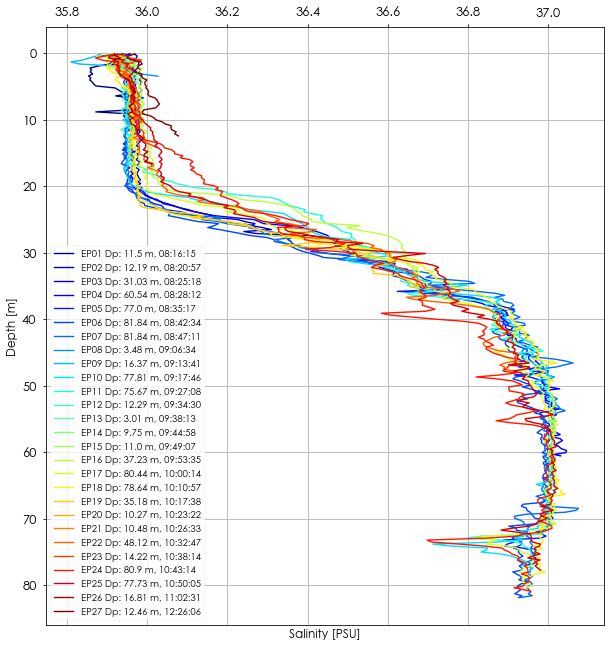

In [8]:
jet= cm.get_cmap('jet', len(paths))
# color_line = viridis.colors[x_1_0]
cNorm=mpl.colors.Normalize(vmin = 0, vmax= len(paths))
scalarMap = cm.ScalarMappable(norm = cNorm, cmap =jet)
fig, ax = plt.subplots(figsize=(10,11))
for i in range (0, len(paths)):
    colorVal = scalarMap.to_rgba(i)
    p1 = ax.plot(Datos[Puntos[i]].Sal.values,Datos[Puntos[i]].Depth.values,color=colorVal\
                 ,ls ='-', label = str(Puntos[i][0:4])+' Dp: '+ str(round(DepthEnd[i],2))+' m, '+str(time[i][0])[11:19])
ax.set_ylabel('Depth [m]',size=12)
ax.set_xlabel('Salinity [PSU]',size=12)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.grid()
_= ax.legend(fontsize=9.5)

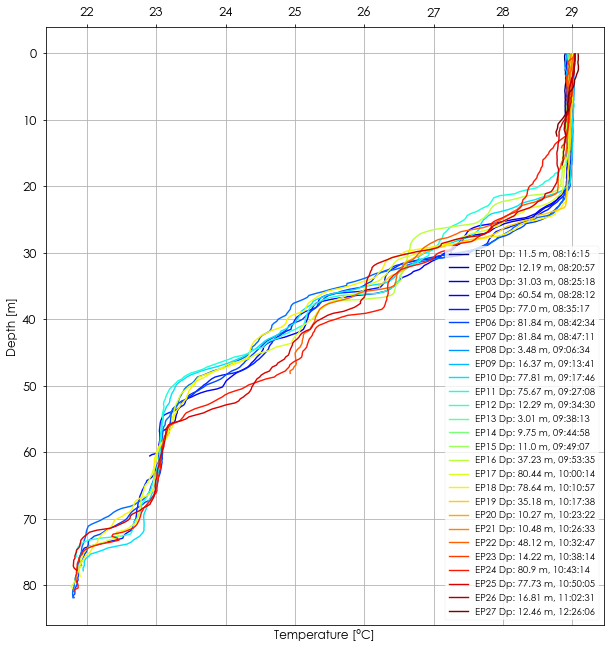

In [9]:
jet= cm.get_cmap('jet', len(paths))
# color_line = viridis.colors[x_1_0]
cNorm=mpl.colors.Normalize(vmin = 0, vmax= len(paths))
scalarMap = cm.ScalarMappable(norm = cNorm, cmap =jet)
fig, ax = plt.subplots(figsize=(10,11))
for i in range (0, len(paths)):
    colorVal = scalarMap.to_rgba(i)
    p1 = ax.plot(Datos[Puntos[i]].Temp.values,Datos[Puntos[i]].Depth.values,color=colorVal\
                 ,ls ='-', label = str(Puntos[i][0:4])+' Dp: '+ str(round(DepthEnd[i],2))+' m, '+str(time[i][0])[11:19])
ax.set_ylabel('Depth [m]',size=12)
ax.set_xlabel('Temperature [°C]',size=12)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.grid()
_= ax.legend(loc = 4, fontsize=9.5)

In [21]:
time_str = [str(time[i][0]) for i in range(0, len(paths))]
time_data = np.array([datetime.strptime(i,'%Y-%m-%d %H:%M:%S') for i in time_str])
df_depth = pd.DataFrame(data = np.c_[time_data,DepthEnd,lat,lon], columns=['time','Depth','lat','lon'])
df_sort = df_depth.sort_values('Depth')
df_sort

,time,Depth,lat,lon
12,2021-11-13 09:38:13,3.00711,12.5751,-81.7235
7,2021-11-13 09:06:34,3.48228,12.5774,-81.7232
13,2021-11-13 09:44:58,9.75355,12.5714,-81.7233
19,2021-11-13 10:23:22,10.2668,12.5694,-81.7251
20,2021-11-13 10:26:33,10.4768,12.5695,-81.724
14,2021-11-13 09:49:07,11.0046,12.5711,-81.7247
0,2021-11-13 08:16:15,11.4954,12.5732,-81.7235
1,2021-11-13 08:20:57,12.1859,12.5727,-81.725
11,2021-11-13 09:34:30,12.2881,12.5748,-81.7252
26,2021-11-13 12:26:06,12.4575,12.5733,-81.7255


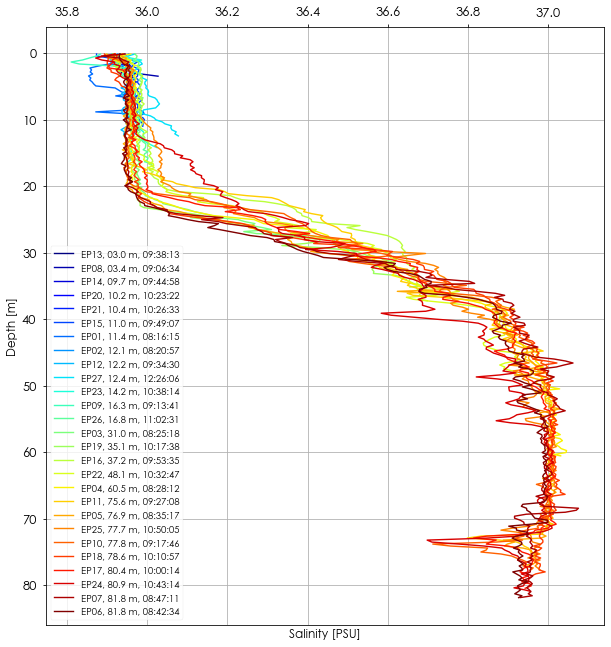

In [11]:
jet= cm.get_cmap('jet', len(paths))
# color_line = viridis.colors[x_1_0]
cNorm=mpl.colors.Normalize(vmin = 0, vmax= len(paths))
scalarMap = cm.ScalarMappable(norm = cNorm, cmap =jet)
fig, ax = plt.subplots(figsize=(10,11))
for i in range (0, len(paths)):
    colorVal = scalarMap.to_rgba(i)
    p1 = ax.plot(Datos_Dp[Puntos_Dp[i]].Sal.values,Datos_Dp[Puntos_Dp[i]].Depth.values,color=colorVal\
                 ,ls ='-', label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m, '+str(df_sort.index[i])[11:19])
ax.set_ylabel('Depth [m]',size=12)
ax.set_xlabel('Salinity [PSU]',size=12)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.grid()
_= ax.legend(fontsize=9.5)

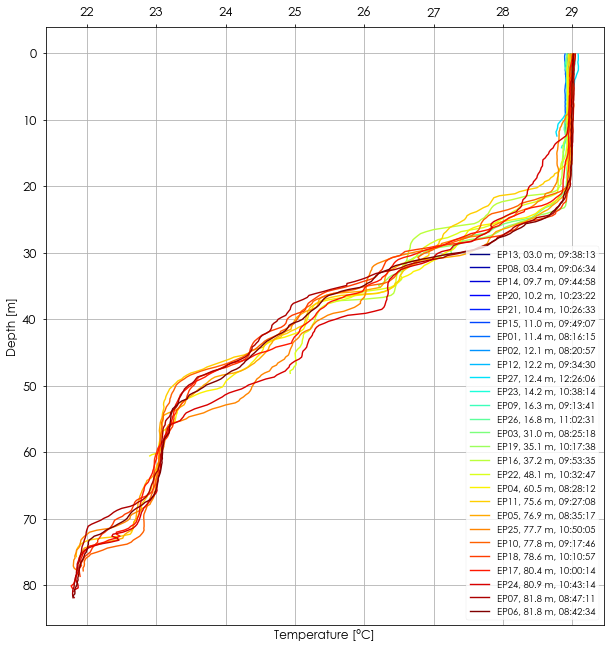

In [12]:
jet= cm.get_cmap('jet', len(paths))
# color_line = viridis.colors[x_1_0]
cNorm=mpl.colors.Normalize(vmin = 0, vmax= len(paths))
scalarMap = cm.ScalarMappable(norm = cNorm, cmap =jet)
fig, ax = plt.subplots(figsize=(10,11))
for i in range (0, len(paths)):
    colorVal = scalarMap.to_rgba(i)
    p1 = ax.plot(Datos_Dp[Puntos_Dp[i]].Temp.values,Datos_Dp[Puntos_Dp[i]].Depth.values,color=colorVal\
                 ,ls ='-', label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m, '+str(df_sort.index[i])[11:19])
ax.set_ylabel('Depth [m]',size=12)
ax.set_xlabel('Temperature [°C]',size=12)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.grid()
_= ax.legend(fontsize=9.5)

# Mapa

In [13]:
## ----------------Lecutra de la batimetría 50m------------------
#-------------------------------------
pi, nan = np.pi, np.nan
delta = 0.00044999999999998                                        # Tamaño de la grilla 
x = np.array ([-81.756419305207 + i*delta for i in range(324)]) # Menor longitud, Numero de divisiones revisar archivo ASCI (output ARCGIS)
y = np.array ([12.460924618377+ i*delta for i in range (407)])        # Menor Latitud,  Numero de divisiones revisar archivo ASCI (output ARCGIS)
z = np.flipud(np.genfromtxt(r'E:/Documentos/Universidad Nacional/TDG_Paula/SWAN/SIMU_NOSTAT/Caso7/M_50m/idw_50m.txt',skip_header = 6))
z[z == -9999] = nan # Z donde es tierra
# suavizar batimetria y recortar bordes
# -------------------------------------
kernel = np.ones((1,1))/1.
z_smooth = signal.convolve2d(z, kernel, "same")
z_smooth = np.ma.masked_array(z, mask=np.isnan(z_smooth))
x_new = x.copy()
y_new = y.copy()
z_new = z_smooth.copy()
#----------------Lectura linea de costa-----------------
lc = np.genfromtxt(r'E:/Documentos/Universidad Nacional/TDG_Paula/SWAN/SIMU_NOSTAT/Caso7/M_Grande/lineaCosta_full.txt',\
                   missing_values = 'nan',delimiter = ' ')
lc[:,0] = lc[:,0]  

In [22]:
#---------------Ubicacion de puntos en mapa------------------------------------
Lat_map = np.zeros(shape = len(paths))
Lon_map = np.zeros(shape = len(paths))
for i in range (0, len(paths)):
    indlat = np.where((df_sort.lat.values[i]<(y+0.00025)) & (df_sort.lat.values[i]>(y-0.00025)))[0][0]
    indlon = np.where((df_sort.lon.values[i]<(x+0.00025)) & (df_sort.lon.values[i]>(x-0.00025)))[0][0]
#     print(indlat)
    Lat_map[i] = y[indlat]
    Lon_map[i] = x[indlon]

df_sort['latMap'] = Lat_map 
df_sort['lonMap'] = Lon_map
df_sort['errorlat'] = abs(df_sort.latMap.values - df_sort.lat.values)*(111100)
df_sort['errorlon'] = abs(df_sort.lonMap.values - df_sort.lon.values)*(111100)
df_crono = df_sort.sort_values('time')

In [15]:
df_sort

,Depth,lat,lon,latMap,lonMap,errorlat,errorlon
2021-11-13 09:38:13,3.007108,12.575088,-81.723488,12.575225,-81.723569,15.122752,8.999678
2021-11-13 09:06:34,3.482278,12.577386,-81.723247,12.577475,-81.723119,9.823282,14.231332
2021-11-13 09:44:58,9.753550,12.571374,-81.723345,12.571175,-81.723569,22.173518,24.942528
2021-11-13 10:23:22,10.266801,12.569450,-81.725080,12.569375,-81.724919,8.352678,17.842082
2021-11-13 10:26:33,10.476834,12.569459,-81.723986,12.569375,-81.724019,9.374798,3.711318
2021-11-13 09:49:07,11.004626,12.571142,-81.724725,12.571175,-81.724919,3.579462,21.565088
2021-11-13 08:16:15,11.495392,12.573212,-81.723473,12.572975,-81.723569,26.350878,10.666178
2021-11-13 08:20:57,12.185925,12.572735,-81.725049,12.572525,-81.724919,23.384508,14.431312
2021-11-13 09:34:30,12.288145,12.574814,-81.725177,12.574775,-81.725369,4.419738,21.376218
2021-11-13 12:26:06,12.457517,12.573259,-81.725507,12.573425,-81.725369,18.377982,15.342332


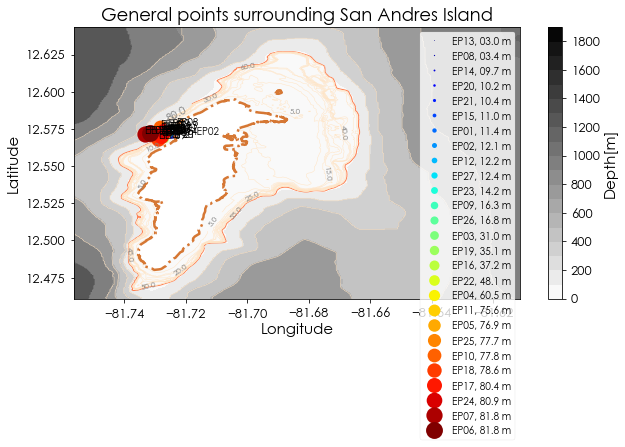

In [16]:
# crear figura
# ------------
fig, ax = plt.subplots(figsize = (10,5))
# colormap = reverse_colourmap(cm.RdYlBu)
# colormap = reverse_colourmap(cm.YlGnBu)
# colormap = cm.Blues
colormap = cm.binary
pc = ax.contourf(x_new, y_new, z_new,levels = np.arange(0,2000,100),cmap = colormap)
cb=plt.colorbar(pc)
 
a = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,100,80)),colors="coral",\
               linewidths=1)
b = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,1000,200)),colors="bisque",\
               linewidths=0.5)
c = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,65,5)),colors="bisque",\
               linewidths=0.5)

aa = plt.clabel(a, fontsize=11, inline=1,fmt='%2.1f',colors='gray')
# bb = plt.clabel(b, fontsize=8, inline=1,fmt='%2.1f',colors='k')
cc = plt.clabel(c, fontsize=8, inline=1,fmt='%2.1f',colors='gray')

shp_scatter = np.zeros(shape = len (paths)) 
# for i in range (0, len(paths)):
#     shp_scatter[i] = i+1
#     colorVal = scalarMap.to_rgba(i)
#     ax.scatter(df_sort.lonMap.values[i],df_sort.latMap.values[i],marker="o",color = colorVal,s=shp_scatter[i]*5, \
#                label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m')
for i in range (0, len(paths)):
    shp_scatter[i] = i+1
    colorVal = scalarMap.to_rgba(i)
    ax.plot(df_sort.lonMap.values[i],df_sort.latMap.values[i],marker="o",color = colorVal,ms=shp_scatter[i]/1.6, ls = ' ', \
               label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m')
#------------ Anotar los nombres de los puntos generales--------------------
    if (i != 5) & (i!= 7):
        ax.text(df_sort.lonMap.values[i],df_sort.latMap.values[i],str(Puntos_Dp[i][-4:]), fontsize = 10)
    elif i == 5:
         ax.text(df_sort.lonMap.values[i],df_sort.latMap.values[i],str(Puntos_Dp[i][-4:])+'-'+\
                 str(Puntos_Dp[7][-4:]) , fontsize = 10)
    else: 
        pass
            
plt.xlabel ('Longitude',size=15)
plt.ylabel ('Latitude',size=15)
ax.plot(lc[:,0], lc[:,1], "-.",c='chocolate', lw=2.5, alpha = 0.9)
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
# ax.set_xlim([-81.75, -81.64])
# ax.set_ylim([12.55, 12.62])
cb.set_label('Depth[m]',size=15)
ax.set_title('General points surrounding San Andres Island',size = 18)
_= ax.legend(fontsize = 10)
plt.grid(False)

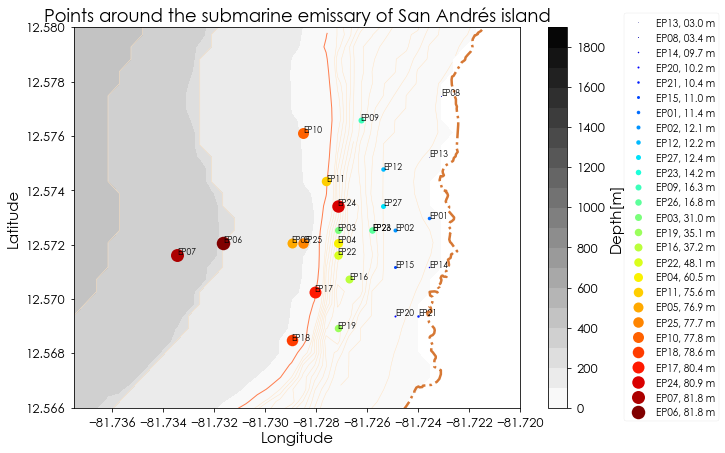

In [17]:
# crear figura
# ------------
fig, ax = plt.subplots(figsize = (10,7))
# colormap = reverse_colourmap(cm.RdYlBu)
# colormap = reverse_colourmap(cm.YlGnBu)
# colormap = cm.Blues
colormap = cm.binary
pc = ax.contourf(x_new, y_new, z_new,levels = np.arange(0,2000,100),cmap = colormap)
cb=plt.colorbar(pc)
#  cb=plt.colorbar(pc, orientation="horizontal")

a = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,100,80)),colors="coral",\
               linewidths=1)
b = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,1000,200)),colors="bisque",\
               linewidths=0.5)
c = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,65,5)),colors="bisque",\
               linewidths=0.5)

aa = plt.clabel(a, fontsize=11, inline=1,fmt='%2.1f',colors='gray')
# bb = plt.clabel(b, fontsize=8, inline=1,fmt='%2.1f',colors='k')
cc = plt.clabel(c, fontsize=8, inline=1,fmt='%2.1f',colors='gray')

shp_scatter = np.zeros(shape = len (paths)) 
# for i in range (0, len(paths)):
#     shp_scatter[i] = i+1
#     colorVal = scalarMap.to_rgba(i)
#     ax.scatter(df_sort.lonMap.values[i],df_sort.latMap.values[i],marker="o",color = colorVal,s=shp_scatter[i]*5, \
#                label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m')
for i in range (0, len(paths)):
    shp_scatter[i] = i+1
    colorVal = scalarMap.to_rgba(i)
    ax.plot(df_sort.lonMap.values[i],df_sort.latMap.values[i],marker="o",color = colorVal,ms=shp_scatter[i]/2, ls = ' ', \
               label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m')
#------------ Anotar los nombres de los puntos generales--------------------
#     if (i != 5) & (i!= 7):
    ax.text(df_sort.lonMap.values[i],df_sort.latMap.values[i],str(Puntos_Dp[i][-4:]), fontsize = 8.5)
#     elif i == 5:
#          ax.text(df_sort.lonMap.values[i],df_sort.latMap.values[i],str(Puntos_Dp[i][-4:])+'-'+\
#                  str(Puntos_Dp[7][-4:]) , fontsize = 10)
#     else: 
#         pass
            
ax.set_xlabel ('Longitude',size=15)
ax.set_ylabel ('Latitude',size=15)
ax.plot(lc[:,0], lc[:,1], "-.",c='chocolate', lw=2.5, alpha = 0.9)
# ax.set_xlim([x_new.min(), x_new.max()])
# ax.set_ylim([y_new.min(), y_new.max()])
ax.set_xlim([-81.7375, -81.720])
ax.set_ylim([12.566, 12.58])
cb.set_label('Depth[m]',size=15)
ax.set_title('Points around the submarine emissary of San Andrés island',size = 18)
_= ax.legend(loc='center left', bbox_to_anchor=(1.22, 0.5),fontsize = 10)
ax.grid(False)

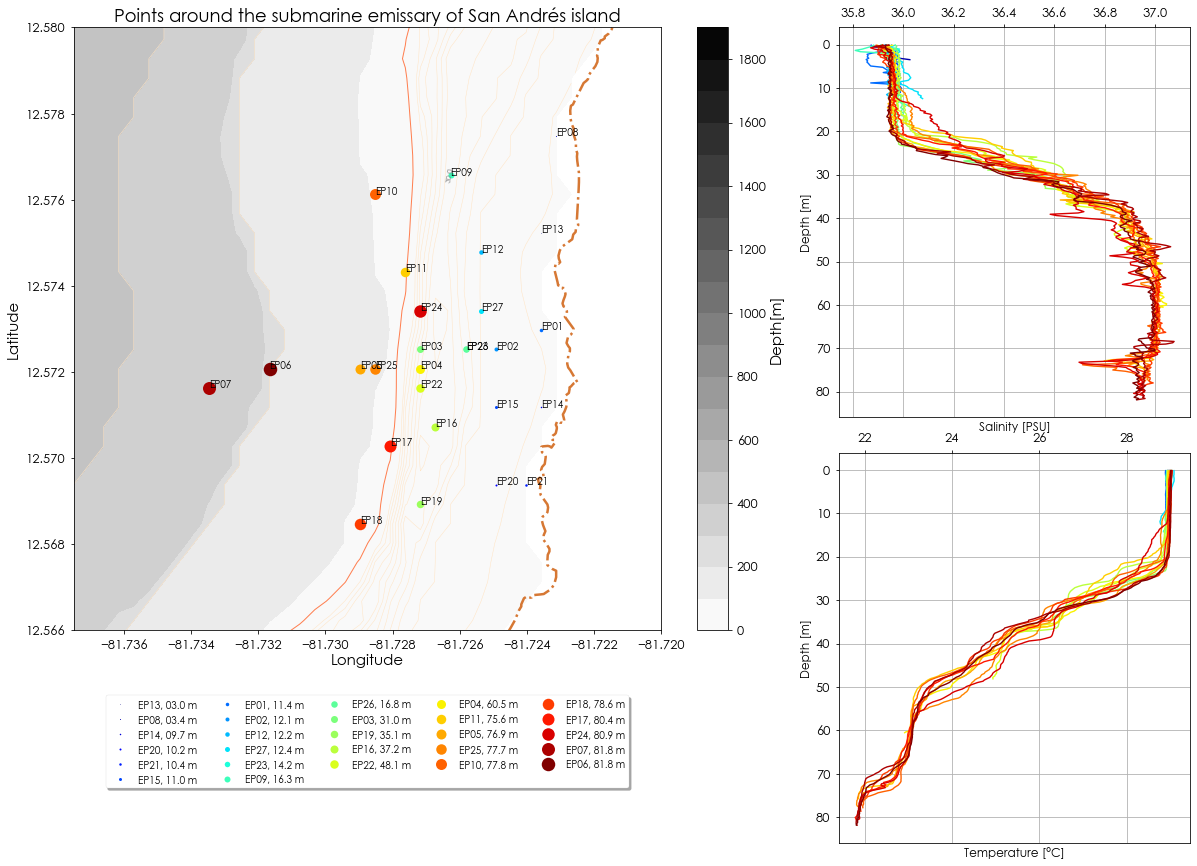

In [18]:
# crear figura
# ------------
plt.close()
fig = plt.figure (figsize = (20,15))
ax = plt.subplot2grid((4,6),(0,0),colspan = 4,rowspan=3)
# ax = plt.subplot(2,3, (1,3))
colormap = cm.binary
pc = ax.contourf(x_new, y_new, z_new,levels = np.arange(0,2000,100),cmap = colormap)
cb=plt.colorbar(pc)
#  cb=plt.colorbar(pc, orientation="horizontal")

a = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,100,80)),colors="coral",\
               linewidths=1)
b = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,1000,200)),colors="bisque",\
               linewidths=0.5)
c = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,65,5)),colors="bisque",\
               linewidths=0.5)

aa = plt.clabel(a, fontsize=11, inline=1,fmt='%2.1f',colors='gray')
# bb = plt.clabel(b, fontsize=8, inline=1,fmt='%2.1f',colors='k')
cc = plt.clabel(c, fontsize=8, inline=1,fmt='%2.1f',colors='gray')

shp_scatter = np.zeros(shape = len (paths)) 
# for i in range (0, len(paths)):
#     shp_scatter[i] = i+1
#     colorVal = scalarMap.to_rgba(i)
#     ax.scatter(df_sort.lonMap.values[i],df_sort.latMap.values[i],marker="o",color = colorVal,s=shp_scatter[i]*5, \
#                label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m')
for i in range (0, len(paths)):
    shp_scatter[i] = i+1
    colorVal = scalarMap.to_rgba(i)
    ax.plot(df_sort.lonMap.values[i],df_sort.latMap.values[i],marker="o",color = colorVal,ms=shp_scatter[i]/2, ls = ' ', \
               label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m')
#------------ Anotar los nombres de los puntos generales--------------------
#     if (i != 5) & (i!= 7):
    ax.text(df_sort.lonMap.values[i],df_sort.latMap.values[i],str(Puntos_Dp[i][-4:]), fontsize = 10)
#     elif i == 5:
#          ax.text(df_sort.lonMap.values[i],df_sort.latMap.values[i],str(Puntos_Dp[i][-4:])+'-'+\
#                  str(Puntos_Dp[7][-4:]) , fontsize = 10)
#     else: 
#         pass
            
ax.set_xlabel ('Longitude',size=15)
ax.set_ylabel ('Latitude',size=15)
ax.plot(lc[:,0], lc[:,1], "-.",c='chocolate', lw=2.5, alpha = 0.9)
# ax.set_xlim([x_new.min(), x_new.max()])
# ax.set_ylim([y_new.min(), y_new.max()])
ax.set_xlim([-81.7375, -81.720])
ax.set_ylim([12.566, 12.58])
cb.set_label('Depth[m]',size=15)
ax.set_title('Points around the submarine emissary of San Andrés island',size = 18)
# _= ax.legend(loc='center left', bbox_to_anchor=(1.22, 0.5),fontsize = 10)
# _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5, fontsize = 10)
_= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5, fontsize = 10)
ax.grid(False)

ax1 = plt.subplot2grid((4,6),(0,4),rowspan=2,colspan=2)
# ax1 = plt.subplot(222)
for i in range (0, len(paths)):
    colorVal = scalarMap.to_rgba(i)
    p1 = ax1.plot(Datos_Dp[Puntos_Dp[i]].Sal.values,Datos_Dp[Puntos_Dp[i]].Depth.values,color=colorVal\
                 ,ls ='-', label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m, '+str(df_sort.index[i])[11:19])
ax1.set_ylabel('Depth [m]',size=12)
ax1.set_xlabel('Salinity [PSU]',size=12)
ax1.xaxis.tick_top()
ax1.invert_yaxis()
ax1.grid()
# ax1.set_figheight(5)
# ax1.set_figwidth(5)
# _= ax1.legend(fontsize=11)

ax2 = plt.subplot2grid((4,6),(2,4),rowspan=2,colspan=2)
# ax2 = plt.subplot(224)
for i in range (0, len(paths)):
    colorVal = scalarMap.to_rgba(i)
    p1 = ax2.plot(Datos_Dp[Puntos_Dp[i]].Temp.values,Datos_Dp[Puntos_Dp[i]].Depth.values,color=colorVal\
                 ,ls ='-', label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m, '+str(df_sort.index[i])[11:19])
ax2.set_ylabel('Depth [m]',size=12)
ax2.set_xlabel('Temperature [°C]',size=12)
ax2.xaxis.tick_top()
ax2.invert_yaxis()
ax2.grid()
# _= ax2.legend(fontsize=11)
ruta = r"E:\Documentos\DATOS_SAI_TODOS\DATOS_SAI_4_15_nov_2021\CTD"  
plt.savefig(ruta+'\Emisario_Profailes_SAI.png',dpi=800,bbox_inches='tight',pad_inches=0)

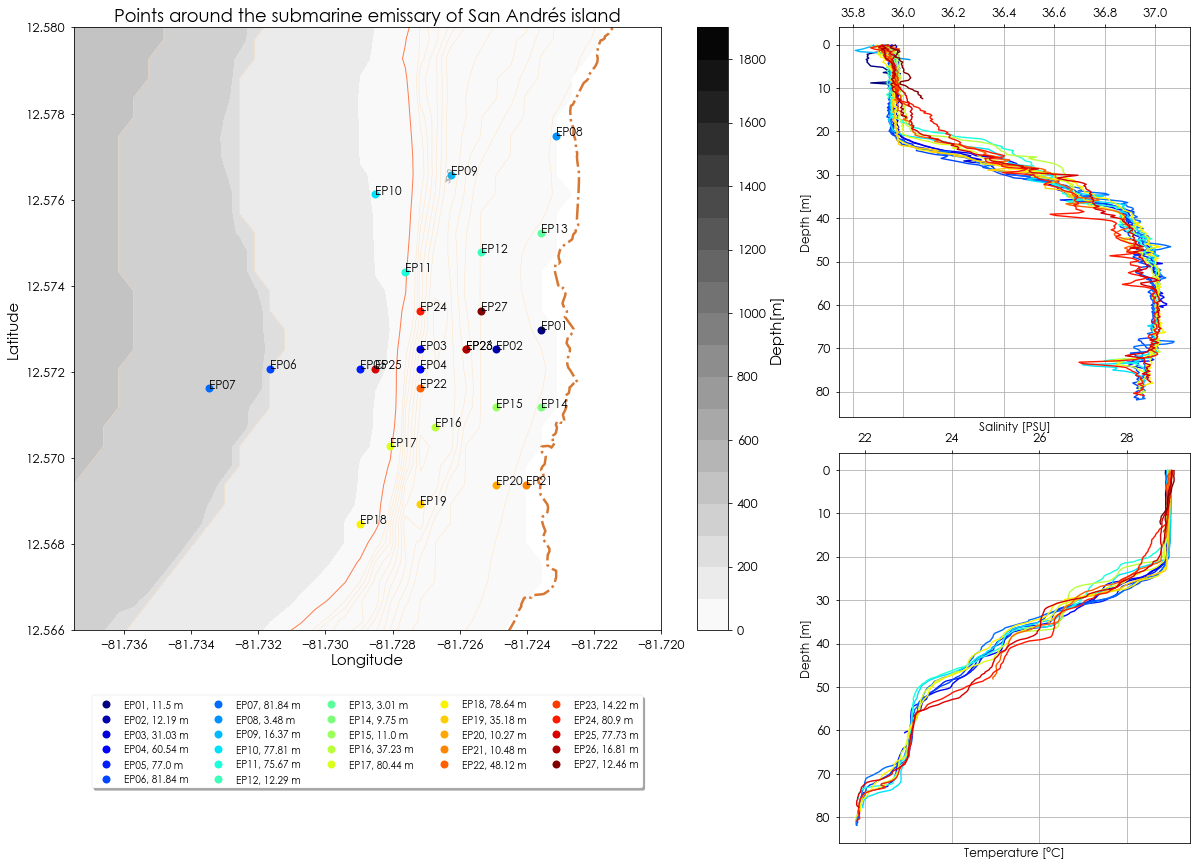

In [26]:
# crear figura
# ------------
plt.close()
fig = plt.figure (figsize = (20,15))
ax = plt.subplot2grid((4,6),(0,0),colspan = 4,rowspan=3)
# ax = plt.subplot(2,3, (1,3))
colormap = cm.binary
pc = ax.contourf(x_new, y_new, z_new,levels = np.arange(0,2000,100),cmap = colormap)
cb=plt.colorbar(pc)
#  cb=plt.colorbar(pc, orientation="horizontal")

a = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,100,80)),colors="coral",\
               linewidths=1)
b = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,1000,200)),colors="bisque",\
               linewidths=0.5)
c = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,65,5)),colors="bisque",\
               linewidths=0.5)

aa = plt.clabel(a, fontsize=11, inline=1,fmt='%2.1f',colors='gray')
# bb = plt.clabel(b, fontsize=8, inline=1,fmt='%2.1f',colors='k')
cc = plt.clabel(c, fontsize=8, inline=1,fmt='%2.1f',colors='gray')

shp_scatter = np.zeros(shape = len (paths)) 
# for i in range (0, len(paths)):
#     shp_scatter[i] = i+1
#     colorVal = scalarMap.to_rgba(i)
#     ax.scatter(df_sort.lonMap.values[i],df_sort.latMap.values[i],marker="o",color = colorVal,s=shp_scatter[i]*5, \
#                label = str(Puntos_Dp[i][-4:])+', '+str(Puntos_Dp[i][0:4])+' m')
for i in range (0, len(paths)):
#     shp_scatter[i] = df_sort.Depth.values[i]/5
    colorVal = scalarMap.to_rgba(i)
    ax.plot(df_crono.lonMap.values[i],df_crono.latMap.values[i],marker="o",color = colorVal,ms=8, ls = ' ', \
               label = str(Puntos[i][0:4])+', '+ str(round(DepthEnd[i],2))+' m')
#------------ Anotar los nombres de los puntos generales--------------------
#     if (i != 0) & (i!= 1):
    ax.text(df_crono.lonMap.values[i],df_crono.latMap.values[i],str(Puntos[i][0:4]), fontsize = 12)
#     elif i == 0:
#          ax.text(df_crono.lonMap.values[i],df_crono.latMap.values[i],str(Puntos[i][0:4])+'-'+\
#                  str(Puntos[1][0:4]) , fontsize = 12)
#     else: 
#         pass
            
ax.set_xlabel ('Longitude',size=15)
ax.set_ylabel ('Latitude',size=15)
ax.plot(lc[:,0], lc[:,1], "-.",c='chocolate', lw=2.5, alpha = 0.9)
# ax.set_xlim([x_new.min(), x_new.max()])
# ax.set_ylim([y_new.min(), y_new.max()])
ax.set_xlim([-81.7375, -81.720])
ax.set_ylim([12.566, 12.58])
cb.set_label('Depth[m]',size=15)
ax.set_title('Points around the submarine emissary of San Andrés island',size = 18)
# _= ax.legend(loc='center left', bbox_to_anchor=(1.22, 0.5),fontsize = 10)
# _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5, fontsize = 10)
_= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5, fontsize = 10)
ax.grid(False)

ax1 = plt.subplot2grid((4,6),(0,4),rowspan=2,colspan=2)
# ax1 = plt.subplot(222)
for i in range (0, len(paths)):
    colorVal = scalarMap.to_rgba(i)
    p1 = ax1.plot(Datos[Puntos[i]].Sal.values,Datos[Puntos[i]].Depth.values,color=colorVal\
                 ,ls ='-', label = str(Puntos[i][0:4])+' Dp: '+ str(round(DepthEnd[i],2))+' m, '+str(time[i][0])[11:19])
ax1.set_ylabel('Depth [m]',size=12)
ax1.set_xlabel('Salinity [PSU]',size=12)
ax1.xaxis.tick_top()
ax1.invert_yaxis()
ax1.grid()
# _= ax1.legend(fontsize=11)

ax2 = plt.subplot2grid((4,6),(2,4),rowspan=2,colspan=2)
# ax2 = plt.subplot(224)
for i in range (0, len(paths)):
    colorVal = scalarMap.to_rgba(i)
    p1 = ax2.plot(Datos[Puntos[i]].Temp.values,Datos[Puntos[i]].Depth.values,color=colorVal\
                 ,ls ='-', label = str(Puntos[i][0:4])+' Dp: '+ str(round(DepthEnd[i],2))+' m, '+str(time[i][0])[11:19])
ax2.set_ylabel('Depth [m]',size=12)
ax2.set_xlabel('Temperature [°C]',size=12)
ax2.xaxis.tick_top()
ax2.invert_yaxis()
ax2.grid()
# _= ax2.legend(fontsize=11)
ruta = r"E:\Documentos\DATOS_SAI_TODOS\DATOS_SAI_4_15_nov_2021\CTD"  
plt.savefig(ruta+'\Emissary_Profailes_SAI_2.png',dpi=800,bbox_inches='tight',pad_inches=0)